## Importing required modules

In [1]:
import numpy as np
import pandas as pd
import scipy 
import sklearn
from collections import Counter
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from scipy import spatial

## Loading the data and labels

In [2]:
data = pd.read_csv('../input/kmeans_data/data.csv')
labels = pd.read_csv('../input/kmeans_data/label.csv', names=['label'],header=None)

In [3]:
data.count()

0        9999
0.1      9999
0.2      9999
0.3      9999
0.4      9999
         ... 
0.663    9999
0.664    9999
0.665    9999
0.666    9999
0.667    9999
Length: 784, dtype: int64

## Visualizing the data using K-Means

In [4]:
# Function to implement K-Means on the given data and visualize
def kmeans_visualize(x,k, no_of_iterations):
    idx = np.random.choice( len(x), k, replace=False)
    # Randomly choosing Centroids
    centroids = x[idx, :] #Step 1
    # Finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'cosine') 
    # Step 2
    # Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
    # Repeating the above steps for a defined number of iterations
    # Step 4
    for _ in range(no_of_iterations):
        centroids = []
        for idx in range(k):
            # Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0)
            centroids.append(temp_cent)
    centroids = np.vstack(centroids) #Updated Centroids
    distances = cdist(x, centroids ,'cosine')
    points = np.array([np.argmin(i) for i in distances])
    return points

In [5]:
# Loading the Data
dataset = pd.read_csv('../input/kmeans_data/data.csv')
pca = PCA(2)

In [6]:
# Transforming the data using PCA
df = pca.fit_transform(dataset)

In [7]:
# Applying K-Means Visualize function
label = kmeans_visualize(df,10,1000)

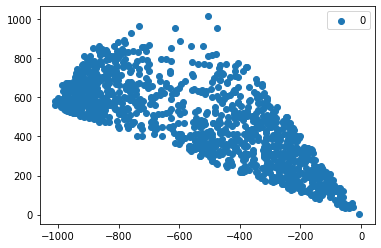

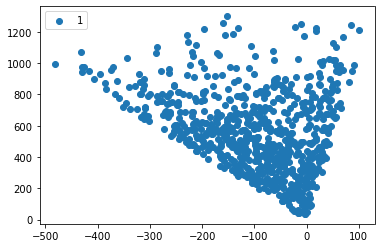

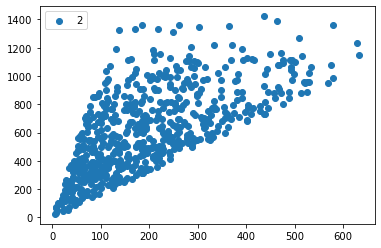

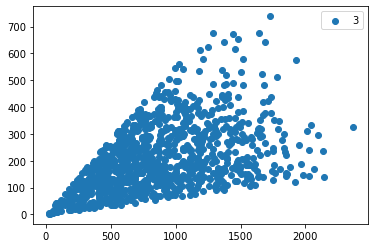

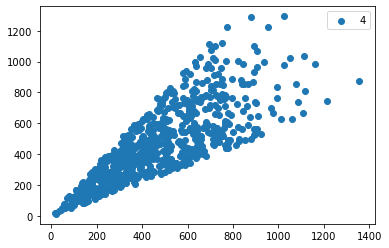

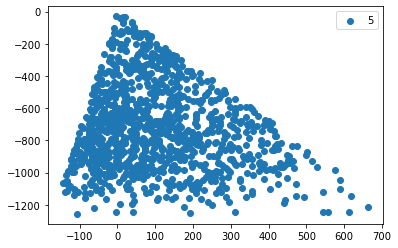

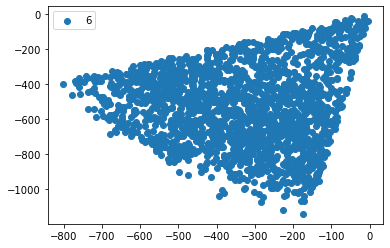

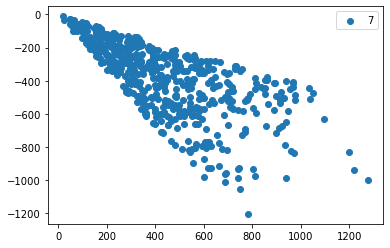

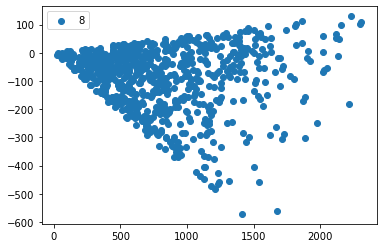

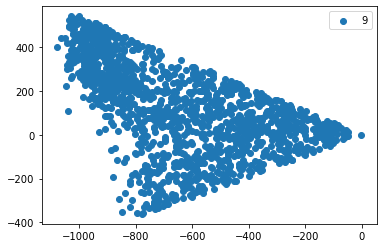

In [8]:
# Visualizing the results based on the each unique label
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
    plt.legend()
    plt.show()

## Splitting the train and test data

In [9]:
from sklearn.model_selection import train_test_split
train_values, test_values = train_test_split(data, test_size = 0.08, random_state = 50)
train_label_val, test_label_val = train_test_split(labels, test_size = 0.08, random_state = 50)

## Creating common required functions

In [10]:
# Method to calculate Sum of Squared Errors(SSE)
def calculate_SSE(centroid_value_dict, centroid_dict,data):
    sse = 0
    for i in centroid_dict:
        sse_cluster = 0
        for j in centroid_dict[i]:
            dp = list(data.iloc[int(j)])
            for a,b in zip(centroid_value_dict[i],dp):
                sse_cluster += (a-b)**2
        sse+=sse_cluster
    return sse

In [11]:
# Method to Initialize Centroids
def Initialize_Centroids(data,K):
    p = data.shape[0]
    centroid_value_dict={}
    for i in range(K):
        r = np.random.randint(0, p-1)
        centroid_value_dict[i] = data.iloc[r]
    return centroid_value_dict

In [12]:
# Method to calculate Jaccard
def jaccard_similarity(centroid, dp):
    top = len(list(set(centroid).intersection(dp)))
    bottom = (len(set(centroid)) + len(set(dp))) - top
    return float(top) / bottom

In [13]:
# Method to train K-Means
def train_Kmeans(data,K,max_iter=20,mode=1,tol=10):
    centroid_value_dict = Initialize_Centroids(data,K)
    count = 0
    centroid_dict = {}
    flag = False
    while((count<max_iter) and not flag):
            
        for i in list(centroid_value_dict.keys()):
            centroid_dict[i]=[]
        for i in range(data.shape[0]):
            x = data.iloc[i]
            if mode==1 :
                distance_measure = [np.linalg.norm(x-centroid_value_dict[j])  for j in centroid_value_dict]
                idx = np.argmin(distance_measure)
                centroid_dict[idx].append(i)
            elif mode==2 :
                distance_measure = [jaccard_similarity(list(x),centroid_value_dict[j]) for j in centroid_value_dict]
                idx = np.argmax(distance_measure)
                centroid_dict[idx].append(i)
            elif mode==3 :
                distance_measure = [1-scipy.spatial.distance.cosine(x,list(centroid_value_dict[j]))  for j in centroid_value_dict]
                idx = np.argmax(distance_measure)
                centroid_dict[idx].append(i)
                
            prev_centroids=dict(centroid_value_dict)
        for i in centroid_dict:
            if len(centroid_dict[i]):
                dps_centroid = centroid_dict[i]
                centroid_value_dict[i] = np.average(data.iloc[dps_centroid],axis=0)
        current_tol=-1
        for i in centroid_value_dict:
            prev_centroid_point = prev_centroids[i]
            new_centroid_point = centroid_value_dict[i]
            change = np.sum(np.absolute(new_centroid_point-prev_centroid_point))
            current_tol = max(change, current_tol)
                
        print("Iteration ",count,": ",current_tol)
            
        count+=1
        if (current_tol<10):
            flag = True
            break
    return centroid_value_dict,centroid_dict


In [14]:
# Method to predict the cluster labels
def predict_cluster_labels(centroids, indices, labels):
    cluster_labels = np.zeros(10,dtype=int)
    for c in centroids:
        labels_points = []
        for point in indices[c]:
            labels_points.extend(labels.iloc[point])
        counter = Counter(labels_points)
        try:
            cluster_labels[c] = max(counter, key=counter.get)
        except:
            cluster_labels[c] = np.random.randint(0,9)
    return cluster_labels

In [15]:
# Method to calculate Accuracy
def accuracy(centroids, centroid_Labels, test_data, true_labels, mode=1):
    y_true = list(true_labels['label']);
    y_prd = []
    for index in range(test_data.shape[0]):
        fetset = test_data.iloc[index]
        if mode==1:
            distances = [np.linalg.norm(fetset - centroids[centroid]) for centroid in centroids]
            classification = distances.index(min(distances))
            y_prd.append(centroid_Labels[classification])
        elif mode==2:
            similarity = [jaccard_similarity(fetset, centroids[centroid]) for centroid in centroids]
            classification = similarity.index(max(similarity))
            y_prd.append(centroid_Labels[classification]) 
        elif mode==3:
            similarity = [1 - spatial.distance.cosine(fetset, centroids[centroid]) for centroid in centroids]
            classification = similarity.index(max(similarity))
            y_prd.append(centroid_Labels[classification])
    denominator = test_data.shape[0]
    numarator = 0
    for i in range(0,len(y_prd)):
        if y_true[i] == y_prd[i]:
            numarator += 1
    accuracy = numarator/denominator
    return accuracy

## Calculating Euclidean SSE and Accuracy

In [16]:
centroids1,clusters1 = train_Kmeans(data,10, max_iter=10,mode=1)

Iteration  0 :  24546.18269230769
Iteration  1 :  5332.448817076394
Iteration  2 :  4509.110334279042
Iteration  3 :  3875.4719278945436
Iteration  4 :  2122.337290021137
Iteration  5 :  1696.2906048783148
Iteration  6 :  1623.1300621575679
Iteration  7 :  1723.9096949059312
Iteration  8 :  1486.1605145836481
Iteration  9 :  1611.0338076457092


In [17]:
Euclidean_SSE =calculate_SSE(centroids1,clusters1,data)

In [18]:
print("Euclidean SSE:",Euclidean_SSE)

Euclidean SSE: 25531817558.25777


In [19]:
cluster_labels_euc = predict_cluster_labels(centroids1,clusters1,labels)
cluster_labels_euc

array([0, 5, 5, 9, 8, 3, 7, 1, 3, 2])

In [20]:
Accuracy_Euclidean = accuracy(centroids1, cluster_labels_euc,test_values,test_label_val)
Accuracy_Euclidean

0.09125

## Calculating Jaccard SSE and Accuracy

In [21]:
centroids2,clusters2 =train_Kmeans(data, 10, max_iter = 100, mode = 2)

Iteration  0 :  38669.76315789473
Iteration  1 :  3656.2550977742653
Iteration  2 :  2124.615675572945
Iteration  3 :  1591.885247552166
Iteration  4 :  1539.839281027871
Iteration  5 :  1092.639237329643
Iteration  6 :  1264.1810843246485
Iteration  7 :  716.8411391239997
Iteration  8 :  887.6116136215646
Iteration  9 :  947.9062567273676
Iteration  10 :  1525.0892071850708
Iteration  11 :  677.4228263690486
Iteration  12 :  177.34906324460331
Iteration  13 :  442.0633963551154
Iteration  14 :  0.0


In [22]:
Jaccard_SSE =calculate_SSE(centroids2,clusters2,data)

In [23]:
print("Jacard SSE:",Jaccard_SSE)

Jacard SSE: 34361687572.938736


In [24]:
cluster_labels_jac = predict_cluster_labels(centroids2,clusters2,labels)
cluster_labels_jac

array([1, 2, 3, 1, 0, 1, 3, 5, 4, 6])

In [25]:
Accuracy_Jaccard = accuracy(centroids2, cluster_labels_jac,test_values,test_label_val,mode=2)
Accuracy_Jaccard

0.1025

## Calculating Cosine SSE and Accuracy

In [26]:
centroids3,clusters3 =train_Kmeans(data, 10, max_iter = 100, mode = 3)

Iteration  0 :  32293.729449321625
Iteration  1 :  5239.8377682403425
Iteration  2 :  3539.9907723912956
Iteration  3 :  2666.4597063195497
Iteration  4 :  1949.650325472857
Iteration  5 :  1169.71358100002
Iteration  6 :  835.7827725136164
Iteration  7 :  655.2768303319481
Iteration  8 :  509.6698550856725
Iteration  9 :  421.2182578364724
Iteration  10 :  433.6317594302294
Iteration  11 :  399.7102510809781
Iteration  12 :  396.76144050456173
Iteration  13 :  330.3888116031634
Iteration  14 :  390.34616240241974
Iteration  15 :  337.1983104862578
Iteration  16 :  334.7830649285665
Iteration  17 :  276.163418159353
Iteration  18 :  341.0593236463011
Iteration  19 :  305.4383341070585
Iteration  20 :  353.3039185834755
Iteration  21 :  322.199147928923
Iteration  22 :  317.17628421764107
Iteration  23 :  303.1162975912975
Iteration  24 :  255.93171284718753
Iteration  25 :  283.4098473283749
Iteration  26 :  288.67261671382204
Iteration  27 :  226.362466851703
Iteration  28 :  131.8790

In [27]:
Cosine_SSE = calculate_SSE(centroids3, clusters3, data)

In [28]:
cluster_labels_cos = predict_cluster_labels(centroids3, clusters3, labels)
cluster_labels_cos

array([3, 2, 0, 9, 2, 6, 8, 0, 3, 1])

In [29]:
Accuracy_Cosine = accuracy(centroids3, cluster_labels_cos, test_values, test_label_val, mode = 3)

In [30]:
print("Euclidean accuracy:", Accuracy_Euclidean)
print("Jacard accuracy:", Accuracy_Jaccard)
print("Cosine accuracy :", Accuracy_Cosine)

Euclidean accuracy: 0.09125
Jacard accuracy: 0.1025
Cosine accuracy : 0.1075


In [31]:
print("Euclidean SSE:", Euclidean_SSE)
print("Jacard SSE:", Jaccard_SSE)
print("Cosine SSE :", Cosine_SSE)

Euclidean SSE: 25531817558.25777
Jacard SSE: 34361687572.938736
Cosine SSE : 25618704910.75315
